<a href="https://colab.research.google.com/github/Ray-Aldred/Woke-Tweets/blob/main/complete_roberta_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Sentiment Analysis of 'Woke' and 'Wokeness' Tweets
## Using RoBERTa - State-of-the-Art Twitter Sentiment Analysis

This notebook analyzes tweets containing the terms 'woke' or 'wokeness' using:
- **RoBERTa** - Twitter-trained transformer model (58M tweets)
- Detailed analysis by sentiment category (Positive, Negative, Neutral)
- Username filtering (removes accounts with 'woke' in name unless tweets contain term)
- Top liked tweets and authors per sentiment
- Enhanced word clouds and visualizations

### ⚠️ First Time Setup
Run this in your conda environment or Colab:
```bash
pip install transformers torch pandas numpy matplotlib seaborn wordcloud tqdm scipy
```

## 1. Setup and Configuration

In [1]:
# Import necessary libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
import os
from tqdm.auto import tqdm
warnings.filterwarnings('ignore')

# Transformer model imports
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig
import torch
from scipy.special import softmax

# Word cloud
from wordcloud import WordCloud, STOPWORDS

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Libraries loaded successfully!")
print(f"📍 Current working directory: {os.getcwd()}")
print(f"🔧 PyTorch version: {torch.__version__}")
print(f"🔧 CUDA available: {torch.cuda.is_available()}")

✅ Libraries loaded successfully!
📍 Current working directory: /content
🔧 PyTorch version: 2.9.0+cpu
🔧 CUDA available: False


In [2]:
# ⚙️ CONFIGURATION: Set your file path here
# For Google Colab:
DATA_FILE = r'/content/dataset_tweet-scraper_2024-11-11_23-29-36-565.json'

# For local (uncomment and modify):
# DATA_FILE = 'dataset_tweet-scraper_2024-11-11_23-29-36-565.json'
# DATA_FILE = r'C:\Users\YourName\Downloads\dataset_tweet-scraper_2024-11-11_23-29-36-565.json'

# Create output directory for results
OUTPUT_DIR = 'roberta_analysis_results'
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"📁 Output directory: {OUTPUT_DIR}")

📁 Output directory: roberta_analysis_results


## 2. Load RoBERTa Model

In [3]:
# Load Twitter-trained RoBERTa sentiment model
MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"

print("📥 Loading RoBERTa model...")
print("   (This downloads ~500MB on first run - please wait)")

tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()  # Set to evaluation mode

print(f"✅ Model loaded successfully!")
print(f"🔧 Using device: {device}")
print(f"📊 Model: {MODEL}")
print(f"📊 Labels: Negative (0), Neutral (1), Positive (2)")

📥 Loading RoBERTa model...
   (This downloads ~500MB on first run - please wait)


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

RobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-roberta-base-sentiment-latest
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.pooler.dense.weight     | UNEXPECTED |  | 
roberta.pooler.dense.bias       | UNEXPECTED |  | 
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Model loaded successfully!
🔧 Using device: cpu
📊 Model: cardiffnlp/twitter-roberta-base-sentiment-latest
📊 Labels: Negative (0), Neutral (1), Positive (2)


## 3. Data Loading and Preprocessing

In [4]:
# Load the tweet data
print("📊 Loading tweet data...")
with open(DATA_FILE, 'r', encoding='utf-8') as f:
    tweets_data = json.load(f)

print(f"✅ Loaded {len(tweets_data)} tweets")

📊 Loading tweet data...
✅ Loaded 3000 tweets


In [5]:
# Extract relevant fields into a DataFrame
print("🔄 Processing tweets into DataFrame...")

df = pd.DataFrame([
    {
        'tweet_id': tweet.get('id'),
        'text': tweet.get('fullText', tweet.get('text', '')),
        'likes': tweet.get('likeCount', 0),
        'retweets': tweet.get('retweetCount', 0),
        'replies': tweet.get('replyCount', 0),
        'quotes': tweet.get('quoteCount', 0),
        'views': tweet.get('viewCount', 0),
        'bookmarks': tweet.get('bookmarkCount', 0),
        'created_at': tweet.get('createdAt'),
        'author_name': tweet.get('author', {}).get('name', 'Unknown'),
        'author_username': tweet.get('author', {}).get('userName', 'Unknown'),
        'author_followers': tweet.get('author', {}).get('followers', 0),
        'author_verified': tweet.get('author', {}).get('isBlueVerified', False),
        'is_reply': tweet.get('isReply', False),
        'is_retweet': tweet.get('isRetweet', False),
        'lang': tweet.get('lang', 'unknown')
    }
    for tweet in tweets_data
])

# Convert created_at to datetime
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

# Calculate total engagement
df['total_engagement'] = df['likes'] + df['retweets'] + df['replies'] + df['quotes']

# Filter for English tweets only
df_en = df[df['lang'] == 'en'].copy()

print(f"✅ Data preprocessed!")
print(f"Total tweets: {len(df)}")
print(f"English tweets: {len(df_en)}")
print(f"\nDataFrame shape: {df_en.shape}")

🔄 Processing tweets into DataFrame...
✅ Data preprocessed!
Total tweets: 3000
English tweets: 3000

DataFrame shape: (3000, 17)


## 4. Filter Out 'Woke' Usernames

In [6]:
print("🔍 FILTERING USERNAMES")
print("=" * 80)
print("Removing accounts with 'woke/wokeness' in username unless tweet contains these terms...")

# Function to check if username contains woke/wokeness
def username_contains_woke(username):
    """Check if username contains 'woke' or 'wokeness'"""
    username_lower = str(username).lower()
    return 'woke' in username_lower

# Function to check if tweet text contains woke/wokeness
def tweet_contains_woke(text):
    """Check if tweet text contains 'woke' or 'wokeness'"""
    text_lower = str(text).lower()
    return 'woke' in text_lower

# Apply filtering
df_en['username_has_woke'] = df_en['author_username'].apply(username_contains_woke)
df_en['tweet_has_woke'] = df_en['text'].apply(tweet_contains_woke)

# Keep tweets if:
# 1. Username doesn't contain "woke", OR
# 2. Username contains "woke" BUT tweet also contains "woke"
df_filtered = df_en[
    (~df_en['username_has_woke']) |
    (df_en['username_has_woke'] & df_en['tweet_has_woke'])
].copy()

print(f"\n📊 Before filtering: {len(df_en):,} tweets")
print(f"📊 After filtering: {len(df_filtered):,} tweets")
print(f"📊 Removed: {len(df_en) - len(df_filtered):,} tweets")

# Show examples of removed accounts
removed_accounts = df_en[
    df_en['username_has_woke'] & ~df_en['tweet_has_woke']
]['author_username'].value_counts().head(10)

if len(removed_accounts) > 0:
    print(f"\n🚫 Top removed accounts (username has 'woke' but tweets don't):")
    for username, count in removed_accounts.items():
        print(f"   • @{username}: {count} tweets removed")

# Use filtered data for rest of analysis
df_en = df_filtered.copy()
print(f"\n✅ Filtering complete! Using {len(df_en):,} tweets for analysis.")

🔍 FILTERING USERNAMES
Removing accounts with 'woke/wokeness' in username unless tweet contains these terms...

📊 Before filtering: 3,000 tweets
📊 After filtering: 2,147 tweets
📊 Removed: 853 tweets

🚫 Top removed accounts (username has 'woke' but tweets don't):
   • @EndWokeness: 572 tweets removed
   • @AntiWokeMemes: 133 tweets removed
   • @WeAreWoke1776_3: 35 tweets removed
   • @Wokenessisevil: 14 tweets removed
   • @woke8yearold: 12 tweets removed
   • @ShereeWokeAF: 11 tweets removed
   • @total_woke_: 10 tweets removed
   • @WokePandemic: 9 tweets removed
   • @Woke_Dalek: 6 tweets removed
   • @wokesocieties: 6 tweets removed

✅ Filtering complete! Using 2,147 tweets for analysis.


In [7]:
# Basic statistics after filtering
print("📈 Basic Statistics (After Filtering)")
print("=" * 60)
print(f"Date range: {df_en['created_at'].min()} to {df_en['created_at'].max()}")
print(f"\nUnique authors: {df_en['author_username'].nunique()}")
print(f"Original tweets: {(~df_en['is_retweet']).sum()}")
print(f"Retweets: {df_en['is_retweet'].sum()}")
print(f"Replies: {df_en['is_reply'].sum()}")
print(f"\nVerified authors: {df_en['author_verified'].sum()} ({df_en['author_verified'].mean()*100:.1f}%)")

📈 Basic Statistics (After Filtering)
Date range: 2024-09-30 01:37:58+00:00 to 2024-11-11 23:07:08+00:00

Unique authors: 1538
Original tweets: 2147
Retweets: 0
Replies: 382

Verified authors: 1590 (74.1%)


## 5. RoBERTa Sentiment Analysis

In [8]:
def analyze_sentiment_roberta(text):
    """
    Analyze sentiment using RoBERTa model.
    Returns: dict with negative, neutral, positive probabilities and compound score
    """
    if not text or not isinstance(text, str) or len(text.strip()) == 0:
        return {
            'negative': 0.0,
            'neutral': 1.0,
            'positive': 0.0,
            'compound': 0.0
        }

    try:
        # Tokenize and truncate to max length
        encoded_input = tokenizer(text, return_tensors='pt', truncation=True, max_length=512)
        encoded_input = {k: v.to(device) for k, v in encoded_input.items()}

        # Get model output
        with torch.no_grad():
            output = model(**encoded_input)

        # Convert to probabilities
        scores = output.logits[0].cpu().numpy()
        scores = softmax(scores)

        # Map to labels (negative, neutral, positive)
        result = {
            'negative': float(scores[0]),
            'neutral': float(scores[1]),
            'positive': float(scores[2]),
            'compound': float(scores[2] - scores[0])  # Range: -1 to 1
        }

        return result

    except Exception as e:
        return {
            'negative': 0.0,
            'neutral': 1.0,
            'positive': 0.0,
            'compound': 0.0
        }

def categorize_sentiment(compound_score, pos_prob, neg_prob):
    """
    Categorize sentiment based on probabilities.
    Uses the highest probability class.
    """
    if pos_prob > neg_prob and pos_prob > 0.4:
        return 'Positive'
    elif neg_prob > pos_prob and neg_prob > 0.4:
        return 'Negative'
    else:
        return 'Neutral'

print("✅ Sentiment analysis functions defined")

✅ Sentiment analysis functions defined


In [9]:
# Apply RoBERTa sentiment analysis to all tweets
print("🔍 Performing RoBERTa sentiment analysis on all tweets...")
print(f"Processing {len(df_en)} tweets...")
print("⏳ This may take several minutes depending on your hardware.")
print("")

# Initialize tqdm for progress bar
tqdm.pandas(desc="Analyzing sentiment")

# Apply sentiment analysis with progress bar
sentiment_results = df_en['text'].progress_apply(analyze_sentiment_roberta)

# Extract individual components
df_en['sentiment_negative'] = sentiment_results.apply(lambda x: x['negative'])
df_en['sentiment_neutral'] = sentiment_results.apply(lambda x: x['neutral'])
df_en['sentiment_positive'] = sentiment_results.apply(lambda x: x['positive'])
df_en['sentiment_compound'] = sentiment_results.apply(lambda x: x['compound'])

# Categorize sentiment
df_en['sentiment_category'] = df_en.apply(
    lambda row: categorize_sentiment(
        row['sentiment_compound'],
        row['sentiment_positive'],
        row['sentiment_negative']
    ),
    axis=1
)

print("\n✅ Sentiment analysis complete!")
print(f"\n📊 Sentiment Distribution:")
print(df_en['sentiment_category'].value_counts())
print(f"\n📊 Percentage Distribution:")
print(df_en['sentiment_category'].value_counts(normalize=True) * 100)

🔍 Performing RoBERTa sentiment analysis on all tweets...
Processing 2147 tweets...
⏳ This may take several minutes depending on your hardware.



Analyzing sentiment:   0%|          | 0/2147 [00:00<?, ?it/s]


✅ Sentiment analysis complete!

📊 Sentiment Distribution:
sentiment_category
Negative    1231
Neutral      511
Positive     405
Name: count, dtype: int64

📊 Percentage Distribution:
sentiment_category
Negative    57.335817
Neutral     23.800652
Positive    18.863531
Name: proportion, dtype: float64


## 6. Detailed Analysis by Sentiment Category

In [10]:
print("\n" + "=" * 80)
print("📊 DETAILED ANALYSIS BY SENTIMENT CATEGORY")
print("=" * 80)

for sentiment in ['Positive', 'Negative', 'Neutral']:
    sentiment_df = df_en[df_en['sentiment_category'] == sentiment]

    print(f"\n{'=' * 80}")
    print(f"{'  ' + sentiment.upper() + ' TWEETS  ':^80}")
    print(f"{'=' * 80}")

    print(f"\n📈 Overview:")
    print(f"   • Total tweets: {len(sentiment_df):,}")
    print(f"   • Percentage of all tweets: {len(sentiment_df)/len(df_en)*100:.1f}%")
    print(f"   • Average confidence: {sentiment_df['sentiment_' + sentiment.lower()].mean():.1%}")

    print(f"\n❤️ Engagement Metrics:")
    print(f"   • Total likes: {sentiment_df['likes'].sum():,}")
    print(f"   • Average likes: {sentiment_df['likes'].mean():.1f}")
    print(f"   • Median likes: {sentiment_df['likes'].median():.0f}")
    print(f"   • Total retweets: {sentiment_df['retweets'].sum():,}")
    print(f"   • Average retweets: {sentiment_df['retweets'].mean():.1f}")

    print(f"\n👥 Authors:")
    print(f"   • Unique authors: {sentiment_df['author_username'].nunique():,}")
    print(f"   • Verified authors: {sentiment_df['author_verified'].sum():,} ({sentiment_df['author_verified'].mean()*100:.1f}%)")

    print(f"\n🏆 Top 5 Authors by Total Likes:")
    top_authors = sentiment_df.groupby('author_username')['likes'].sum().nlargest(5)
    for i, (author, likes) in enumerate(top_authors.items(), 1):
        tweet_count = len(sentiment_df[sentiment_df['author_username'] == author])
        avg_likes = likes / tweet_count
        print(f"   {i}. @{author}: {likes:,} likes ({tweet_count} tweets, avg {avg_likes:.0f})")

    print(f"\n📝 Most Liked Tweets:")
    top_tweets = sentiment_df.nlargest(3, 'likes')
    for i, (idx, tweet) in enumerate(top_tweets.iterrows(), 1):
        print(f"\n   {i}. @{tweet['author_username']} | {tweet['likes']:,} ❤️")
        print(f"      {tweet['text'][:200]}{'...' if len(tweet['text']) > 200 else ''}")


📊 DETAILED ANALYSIS BY SENTIMENT CATEGORY

                                POSITIVE TWEETS                                 

📈 Overview:
   • Total tweets: 405
   • Percentage of all tweets: 18.9%
   • Average confidence: 77.8%

❤️ Engagement Metrics:
   • Total likes: 899,754
   • Average likes: 2221.6
   • Median likes: 185
   • Total retweets: 85,597
   • Average retweets: 211.4

👥 Authors:
   • Unique authors: 353
   • Verified authors: 292 (72.1%)

🏆 Top 5 Authors by Total Likes:
   1. @terminallyOL: 277,359 likes (1 tweets, avg 277359)
   2. @KingJames: 155,737 likes (2 tweets, avg 77868)
   3. @EndWokeness: 135,720 likes (1 tweets, avg 135720)
   4. @TONYxTWO: 56,081 likes (1 tweets, avg 56081)
   5. @robbystarbuck: 32,427 likes (4 tweets, avg 8107)

📝 Most Liked Tweets:

   1. @terminallyOL | 277,359 ❤️
      "people were polite to me and accepted what i told them at face value. i've exposed wokeness."

   2. @EndWokeness | 135,720 ❤️
      OMG HAHAHA 😂🤣💀

Trump just played th

## 7. Top 20 Most Liked Tweets by Sentiment

In [11]:
print("\n" + "=" * 80)
print("🏆 TOP 20 MOST LIKED TWEETS BY SENTIMENT CATEGORY")
print("=" * 80)

for sentiment in ['Positive', 'Negative', 'Neutral']:
    sentiment_df = df_en[df_en['sentiment_category'] == sentiment]

    print(f"\n{'=' * 80}")
    print(f"{sentiment.upper()} TWEETS - Top 20 by Likes")
    print(f"{'=' * 80}")

    top_20 = sentiment_df.nlargest(20, 'likes')

    for i, (idx, row) in enumerate(top_20.iterrows(), 1):
        print(f"\n{i:2d}. @{row['author_username']}")
        print(f"    ❤️ {row['likes']:,} likes | 🔄 {row['retweets']:,} retweets | 💬 {row['replies']:,} replies")
        print(f"    📊 Confidence: {row['sentiment_' + sentiment.lower()]:.1%} | Score: {row['sentiment_compound']:.3f}")
        print(f"    📝 {row['text'][:150]}{'...' if len(row['text']) > 150 else ''}")
        print(f"    🔗 https://twitter.com/{row['author_username']}/status/{row['tweet_id']}")


🏆 TOP 20 MOST LIKED TWEETS BY SENTIMENT CATEGORY

POSITIVE TWEETS - Top 20 by Likes

 1. @terminallyOL
    ❤️ 277,359 likes | 🔄 14,485 retweets | 💬 570 replies
    📊 Confidence: 63.5% | Score: 0.615
    📝 "people were polite to me and accepted what i told them at face value. i've exposed wokeness."
    🔗 https://twitter.com/terminallyOL/status/1846516154577109244

 2. @EndWokeness
    ❤️ 135,720 likes | 🔄 22,939 retweets | 💬 2,091 replies
    📊 Confidence: 42.2% | Score: 0.274
    📝 OMG HAHAHA 😂🤣💀

Trump just played this epic clip of our old military vs our new woke military: https://t.co/RlLdutL2jc
    🔗 https://twitter.com/EndWokeness/status/1844113704746615286

 3. @KingJames
    ❤️ 119,708 likes | 🔄 4,514 retweets | 💬 5,011 replies
    📊 Confidence: 96.8% | Score: 0.964
    📝 Just woke up from having a dream I was playing for Duke for Coach K inside Cameron Indoor Stadium! It was INSANE in there. Told Coach K it was an hono...
    🔗 https://twitter.com/KingJames/status/18556399120

## 8. Enhanced Word Clouds by Sentiment

🎨 Creating enhanced word clouds...


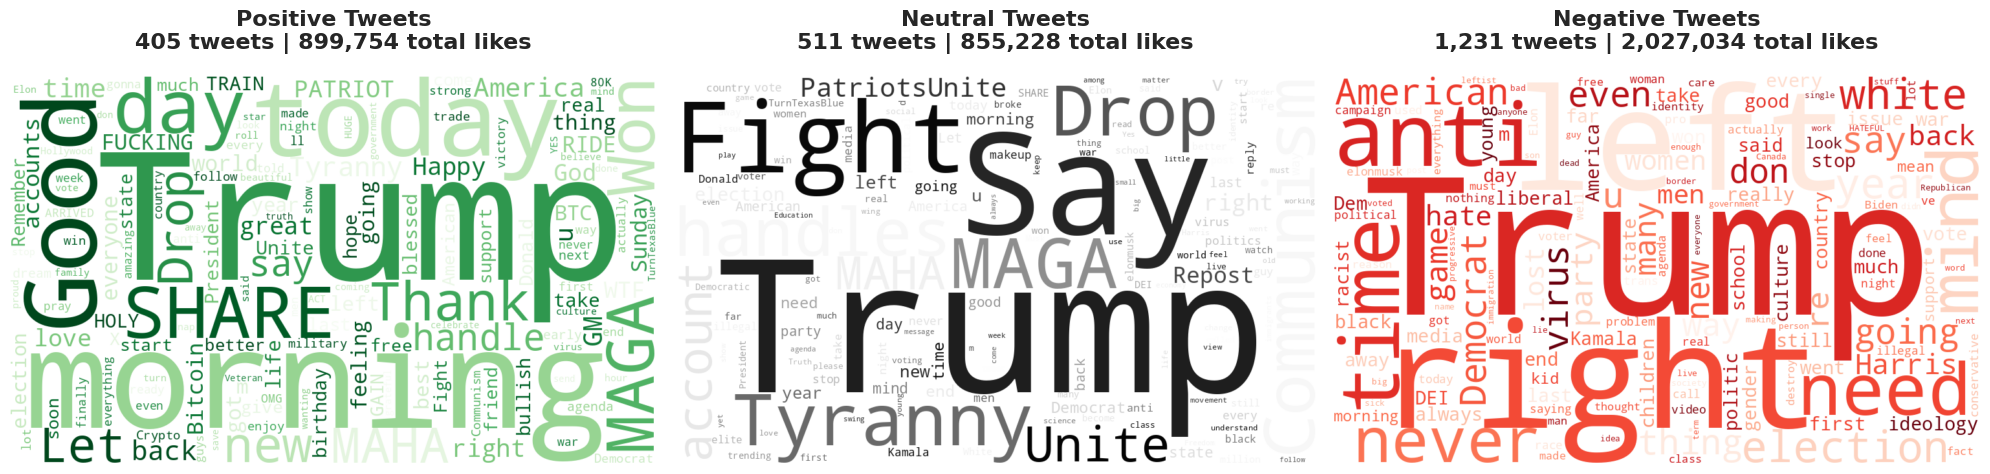

✅ Enhanced word clouds created!


In [12]:
print("🎨 Creating enhanced word clouds...")

# Enhanced stopwords - remove common Twitter terms and the search terms
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    'https', 'http', 'co', 't', 'amp', 's', 'rt', 'via',
    'woke', 'wokeness', 'wokes',  # Remove search terms
    'will', 'just', 'now', 'get', 'one', 'like', 'can',
    'go', 'know', 'people', 'make', 'want', 'think', 'see'
])

fig, axes = plt.subplots(1, 3, figsize=(20, 7))

sentiments = ['Positive', 'Neutral', 'Negative']
colors_wc = ['Greens', 'Greys', 'Reds']

for idx, (sentiment, cmap) in enumerate(zip(sentiments, colors_wc)):
    sentiment_df = df_en[df_en['sentiment_category'] == sentiment]
    text = ' '.join(sentiment_df['text'].astype(str))

    if text.strip():
        wordcloud = WordCloud(
            width=1000,
            height=600,
            background_color='white',
            stopwords=custom_stopwords,
            colormap=cmap,
            max_words=150,
            relative_scaling=0.5,
            min_font_size=10,
            collocations=False
        ).generate(text)

        axes[idx].imshow(wordcloud, interpolation='bilinear')
        axes[idx].set_title(
            f'{sentiment} Tweets\n{len(sentiment_df):,} tweets | {sentiment_df["likes"].sum():,} total likes',
            fontsize=16, fontweight='bold', pad=20
        )
        axes[idx].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'wordcloud_by_sentiment.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ Enhanced word clouds created!")

## 9. Top Authors by Likes - Per Sentiment


👑 TOP AUTHORS BY LIKES - PER SENTIMENT CATEGORY


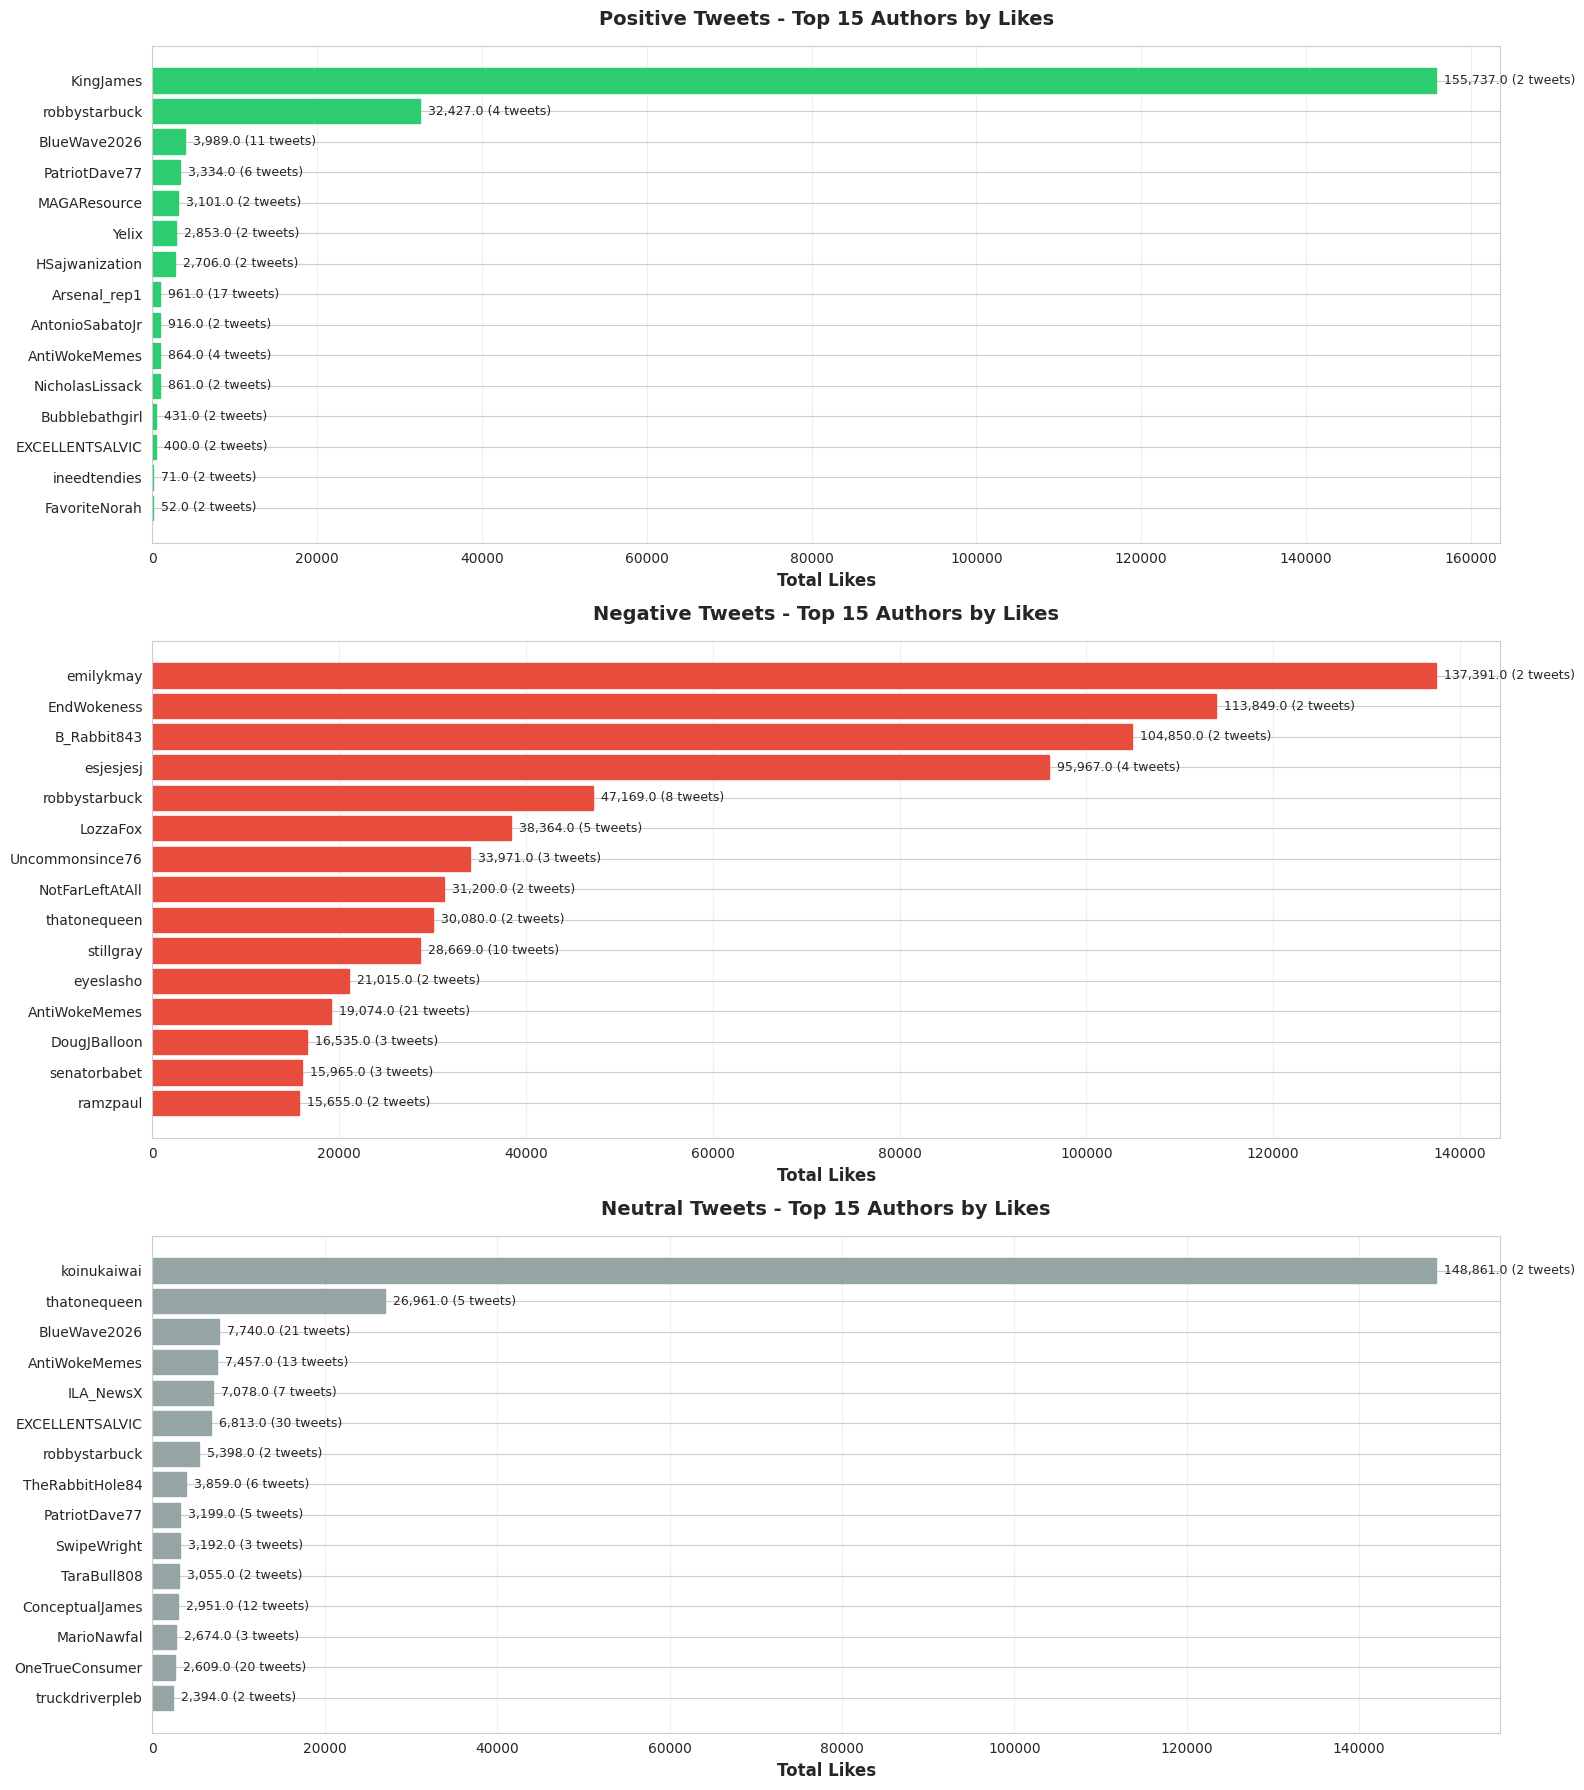

✅ Author rankings by sentiment created!


In [13]:
print("\n" + "=" * 80)
print("👑 TOP AUTHORS BY LIKES - PER SENTIMENT CATEGORY")
print("=" * 80)

fig, axes = plt.subplots(3, 1, figsize=(16, 18))

for idx, sentiment in enumerate(['Positive', 'Negative', 'Neutral']):
    sentiment_df = df_en[df_en['sentiment_category'] == sentiment]

    # Get top 15 authors by total likes in this sentiment
    author_stats = sentiment_df.groupby('author_username').agg({
        'likes': ['sum', 'mean', 'count'],
        'retweets': 'sum',
        'author_followers': 'first'
    })
    author_stats.columns = ['total_likes', 'avg_likes', 'tweet_count', 'total_retweets', 'followers']
    author_stats = author_stats[author_stats['tweet_count'] >= 2]  # At least 2 tweets
    author_stats = author_stats.nlargest(15, 'total_likes')

    ax = axes[idx]

    # Create horizontal bar chart
    bars = ax.barh(range(len(author_stats)), author_stats['total_likes'])

    # Color bars by sentiment
    for i, bar in enumerate(bars):
        if sentiment == 'Positive':
            bar.set_color('#2ecc71')
        elif sentiment == 'Negative':
            bar.set_color('#e74c3c')
        else:
            bar.set_color('#95a5a6')

    ax.set_yticks(range(len(author_stats)))
    ax.set_yticklabels(author_stats.index)
    ax.set_xlabel('Total Likes', fontsize=12, fontweight='bold')
    ax.set_title(f'{sentiment} Tweets - Top 15 Authors by Likes',
                 fontsize=14, fontweight='bold', pad=15)
    ax.invert_yaxis()

    # Add value labels
    for i, (username, row) in enumerate(author_stats.iterrows()):
        ax.text(row['total_likes'], i,
                f"  {row['total_likes']:,} ({int(row['tweet_count'])} tweets)",
                va='center', fontsize=9)

    # Add grid
    ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'top_authors_by_sentiment.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ Author rankings by sentiment created!")

In [14]:
# Print detailed author tables
for sentiment in ['Positive', 'Negative', 'Neutral']:
    sentiment_df = df_en[df_en['sentiment_category'] == sentiment]

    print(f"\n{'=' * 80}")
    print(f"TOP 15 AUTHORS - {sentiment.upper()} TWEETS")
    print(f"{'=' * 80}")

    author_stats = sentiment_df.groupby('author_username').agg({
        'likes': ['sum', 'mean', 'count'],
        'retweets': 'sum',
        'author_followers': 'first'
    })
    author_stats.columns = ['total_likes', 'avg_likes', 'tweet_count', 'total_retweets', 'followers']
    author_stats = author_stats[author_stats['tweet_count'] >= 2]
    author_stats = author_stats.nlargest(15, 'total_likes')

    print(f"\n{'Rank':<6}{'Author':<25}{'Tweets':<10}{'Total Likes':<15}{'Avg Likes':<12}{'Followers':<12}")
    print("-" * 80)

    for i, (username, row) in enumerate(author_stats.iterrows(), 1):
        print(f"{i:<6}@{username:<24}{int(row['tweet_count']):<10}{row['total_likes']:>13,}  {row['avg_likes']:>10.0f}  {row['followers']:>10,}")


TOP 15 AUTHORS - POSITIVE TWEETS

Rank  Author                   Tweets    Total Likes    Avg Likes   Followers   
--------------------------------------------------------------------------------
1     @KingJames               2             155,737.0       77868  53,040,029.0
2     @robbystarbuck           4              32,427.0        8107   689,441.0
3     @BlueWave2026            11              3,989.0         363    64,764.0
4     @PatriotDave77           6               3,334.0         556    69,554.0
5     @MAGAResource            2               3,101.0        1550    96,798.0
6     @Yelix                   2               2,853.0        1426     7,264.0
7     @HSajwanization          2               2,706.0        1353   268,823.0
8     @Arsenal_rep1            17                961.0          57    12,631.0
9     @AntonioSabatoJr         2                 916.0         458   177,887.0
10    @AntiWokeMemes           4                 864.0         216    87,344.0
11    @Nich

## 10. Sentiment Comparison Visualizations

🎨 Creating sentiment comparison visualizations...


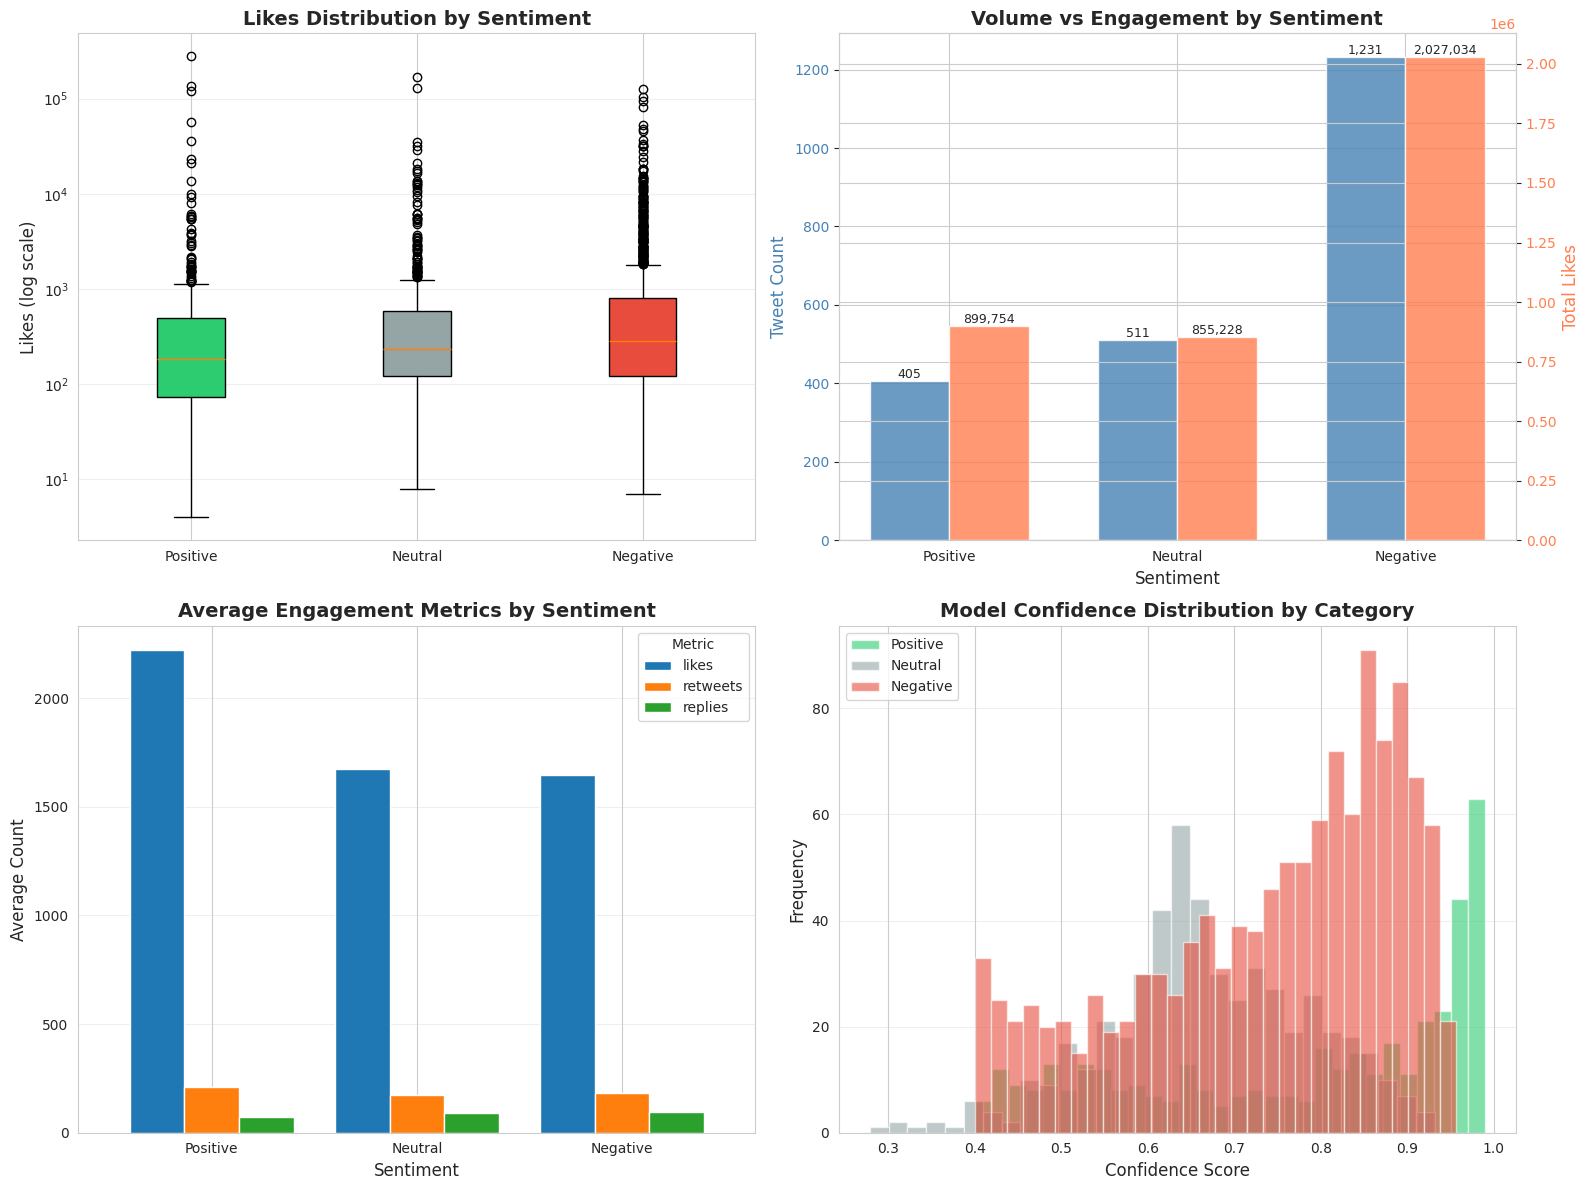

✅ Sentiment comparison visualizations created!


In [15]:
print("🎨 Creating sentiment comparison visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Likes distribution by sentiment (box plot)
ax1 = axes[0, 0]
sentiment_order = ['Positive', 'Neutral', 'Negative']
data_to_plot = [df_en[df_en['sentiment_category'] == s]['likes'] for s in sentiment_order]
bp = ax1.boxplot(data_to_plot, labels=sentiment_order, patch_artist=True)
for patch, sentiment in zip(bp['boxes'], sentiment_order):
    if sentiment == 'Positive':
        patch.set_facecolor('#2ecc71')
    elif sentiment == 'Negative':
        patch.set_facecolor('#e74c3c')
    else:
        patch.set_facecolor('#95a5a6')
ax1.set_ylabel('Likes (log scale)', fontsize=12)
ax1.set_title('Likes Distribution by Sentiment', fontsize=14, fontweight='bold')
ax1.set_yscale('log')
ax1.grid(axis='y', alpha=0.3)

# 2. Tweet count and total likes comparison
ax2 = axes[0, 1]
sentiment_stats = df_en.groupby('sentiment_category').agg({
    'tweet_id': 'count',
    'likes': 'sum'
})
sentiment_stats = sentiment_stats.reindex(['Positive', 'Neutral', 'Negative'])

x = np.arange(len(sentiment_stats))
width = 0.35

ax2_twin = ax2.twinx()
bars1 = ax2.bar(x - width/2, sentiment_stats['tweet_id'], width,
                label='Tweet Count', color='steelblue', alpha=0.8)
bars2 = ax2_twin.bar(x + width/2, sentiment_stats['likes'], width,
                     label='Total Likes', color='coral', alpha=0.8)

ax2.set_xlabel('Sentiment', fontsize=12)
ax2.set_ylabel('Tweet Count', fontsize=12, color='steelblue')
ax2_twin.set_ylabel('Total Likes', fontsize=12, color='coral')
ax2.set_title('Volume vs Engagement by Sentiment', fontsize=14, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(sentiment_stats.index)
ax2.tick_params(axis='y', labelcolor='steelblue')
ax2_twin.tick_params(axis='y', labelcolor='coral')

# Add value labels
for i, v in enumerate(sentiment_stats['tweet_id']):
    ax2.text(i - width/2, v, f'{v:,}', ha='center', va='bottom', fontsize=9)
for i, v in enumerate(sentiment_stats['likes']):
    ax2_twin.text(i + width/2, v, f'{v:,}', ha='center', va='bottom', fontsize=9)

# 3. Average engagement metrics
ax3 = axes[1, 0]
engagement_by_sentiment = df_en.groupby('sentiment_category')[['likes', 'retweets', 'replies']].mean()
engagement_by_sentiment = engagement_by_sentiment.reindex(['Positive', 'Neutral', 'Negative'])
engagement_by_sentiment.plot(kind='bar', ax=ax3, width=0.8)
ax3.set_title('Average Engagement Metrics by Sentiment', fontsize=14, fontweight='bold')
ax3.set_xlabel('Sentiment', fontsize=12)
ax3.set_ylabel('Average Count', fontsize=12)
ax3.legend(title='Metric', loc='upper right')
ax3.tick_params(axis='x', rotation=0)
ax3.grid(axis='y', alpha=0.3)

# 4. Confidence scores distribution
ax4 = axes[1, 1]
for sentiment in ['Positive', 'Neutral', 'Negative']:
    confidence_col = 'sentiment_' + sentiment.lower()
    data = df_en[df_en['sentiment_category'] == sentiment][confidence_col]
    ax4.hist(data, bins=30, alpha=0.6, label=sentiment,
             color='#2ecc71' if sentiment == 'Positive' else '#e74c3c' if sentiment == 'Negative' else '#95a5a6')

ax4.set_xlabel('Confidence Score', fontsize=12)
ax4.set_ylabel('Frequency', fontsize=12)
ax4.set_title('Model Confidence Distribution by Category', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'sentiment_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ Sentiment comparison visualizations created!")

## 11. Summary Statistics

In [16]:
# Generate comprehensive summary
print("\n" + "="*80)
print("📊 COMPREHENSIVE RoBERTa SENTIMENT ANALYSIS SUMMARY")
print("="*80)

print("\n1️⃣ DATASET OVERVIEW")
print("-" * 80)
print(f"   • Total tweets analyzed: {len(df_en):,}")
print(f"   • Date range: {df_en['created_at'].min()} to {df_en['created_at'].max()}")
print(f"   • Unique authors: {df_en['author_username'].nunique():,}")
print(f"   • Model used: {MODEL}")

print("\n2️⃣ SENTIMENT ANALYSIS (RoBERTa)")
print("-" * 80)
for sentiment in ['Positive', 'Neutral', 'Negative']:
    count = (df_en['sentiment_category'] == sentiment).sum()
    pct = count / len(df_en) * 100
    print(f"   • {sentiment}: {count:,} tweets ({pct:.1f}%)")

print(f"\n   • Average sentiment score: {df_en['sentiment_compound'].mean():.3f}")
print(f"   • Median sentiment score: {df_en['sentiment_compound'].median():.3f}")
print(f"   • Sentiment std deviation: {df_en['sentiment_compound'].std():.3f}")

print("\n3️⃣ ENGAGEMENT METRICS")
print("-" * 80)
print(f"   • Total likes: {df_en['likes'].sum():,}")
print(f"   • Total retweets: {df_en['retweets'].sum():,}")
print(f"   • Total replies: {df_en['replies'].sum():,}")
print(f"   • Average likes per tweet: {df_en['likes'].mean():.1f}")
print(f"   • Median likes per tweet: {df_en['likes'].median():.0f}")
print(f"   • Most liked tweet: {df_en['likes'].max():,} likes")

print("\n4️⃣ SENTIMENT vs ENGAGEMENT")
print("-" * 80)
for sentiment in ['Positive', 'Neutral', 'Negative']:
    avg_likes = df_en[df_en['sentiment_category'] == sentiment]['likes'].mean()
    total_likes = df_en[df_en['sentiment_category'] == sentiment]['likes'].sum()
    print(f"   • {sentiment}: avg {avg_likes:.1f} likes/tweet | total {total_likes:,} likes")

print("\n5️⃣ KEY INSIGHTS")
print("-" * 80)

# Which sentiment gets more engagement?
sentiment_engagement = df_en.groupby('sentiment_category')['likes'].mean().sort_values(ascending=False)
top_sentiment = sentiment_engagement.index[0]
print(f"   • {top_sentiment} tweets receive the highest average engagement")

# Correlation between sentiment and likes
corr = df_en['sentiment_compound'].corr(df_en['likes'])
print(f"\n   • Correlation between sentiment and likes: {corr:.3f}")
if abs(corr) < 0.1:
    print(f"     → Weak correlation: sentiment doesn't strongly predict engagement")
elif corr > 0:
    print(f"     → Positive correlation: more positive tweets tend to get more likes")
else:
    print(f"     → Negative correlation: more negative tweets tend to get more likes")

# Sentiment confidence
avg_max_prob = df_en[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative']].max(axis=1).mean()
print(f"\n   • Average model confidence: {avg_max_prob:.1%}")

print("\n" + "="*80)


📊 COMPREHENSIVE RoBERTa SENTIMENT ANALYSIS SUMMARY

1️⃣ DATASET OVERVIEW
--------------------------------------------------------------------------------
   • Total tweets analyzed: 2,147
   • Date range: 2024-09-30 01:37:58+00:00 to 2024-11-11 23:07:08+00:00
   • Unique authors: 1,538
   • Model used: cardiffnlp/twitter-roberta-base-sentiment-latest

2️⃣ SENTIMENT ANALYSIS (RoBERTa)
--------------------------------------------------------------------------------
   • Positive: 405 tweets (18.9%)
   • Neutral: 511 tweets (23.8%)
   • Negative: 1,231 tweets (57.3%)

   • Average sentiment score: -0.268
   • Median sentiment score: -0.477
   • Sentiment std deviation: 0.602

3️⃣ ENGAGEMENT METRICS
--------------------------------------------------------------------------------
   • Total likes: 3,782,016
   • Total retweets: 399,638
   • Total replies: 193,587
   • Average likes per tweet: 1761.5
   • Median likes per tweet: 243
   • Most liked tweet: 277,359 likes

4️⃣ SENTIMENT vs ENG

## 12. Export Results

In [17]:
# Save processed data with sentiment scores
output_file = os.path.join(OUTPUT_DIR, 'tweets_with_roberta_sentiment.csv')
df_en.to_csv(output_file, index=False)
print(f"✅ Data with RoBERTa sentiment scores saved to: {output_file}")

# Export sentiment-specific CSV files
print("\n📁 Exporting sentiment-specific CSV files...")
for sentiment in ['Positive', 'Negative', 'Neutral']:
    sentiment_df = df_en[df_en['sentiment_category'] == sentiment]
    filename = os.path.join(OUTPUT_DIR, f'tweets_{sentiment.lower()}_sentiment.csv')
    sentiment_df.to_csv(filename, index=False)
    print(f"✅ Exported {len(sentiment_df):,} {sentiment.lower()} tweets to: {filename}")

# Save summary statistics
summary_stats = {
    'model': MODEL,
    'total_tweets': int(len(df_en)),
    'sentiment_distribution': df_en['sentiment_category'].value_counts().to_dict(),
    'average_sentiment': float(df_en['sentiment_compound'].mean()),
    'median_sentiment': float(df_en['sentiment_compound'].median()),
    'sentiment_std': float(df_en['sentiment_compound'].std()),
    'average_confidence': float(df_en[['sentiment_positive', 'sentiment_neutral', 'sentiment_negative']].max(axis=1).mean()),
    'total_likes': int(df_en['likes'].sum()),
    'average_likes': float(df_en['likes'].mean()),
    'sentiment_likes_correlation': float(df_en['sentiment_compound'].corr(df_en['likes'])),
    'likes_by_sentiment': df_en.groupby('sentiment_category')['likes'].mean().to_dict()
}

summary_file = os.path.join(OUTPUT_DIR, 'summary_statistics.json')
with open(summary_file, 'w') as f:
    json.dump(summary_stats, f, indent=2)

print(f"\n✅ Summary statistics saved to: {summary_file}")
print(f"\n📁 All results saved to: {os.path.abspath(OUTPUT_DIR)}")
print("\n🎉 RoBERTa sentiment analysis complete!")
print("\n📊 Generated files:")
print("  • tweets_with_roberta_sentiment.csv - Full data with sentiment scores")
print("  • tweets_positive_sentiment.csv - Only positive tweets")
print("  • tweets_negative_sentiment.csv - Only negative tweets")
print("  • tweets_neutral_sentiment.csv - Only neutral tweets")
print("  • summary_statistics.json - Key metrics")
print("  • wordcloud_by_sentiment.png - Word clouds")
print("  • top_authors_by_sentiment.png - Author rankings")
print("  • sentiment_comparison.png - Comparison charts")

✅ Data with RoBERTa sentiment scores saved to: roberta_analysis_results/tweets_with_roberta_sentiment.csv

📁 Exporting sentiment-specific CSV files...
✅ Exported 405 positive tweets to: roberta_analysis_results/tweets_positive_sentiment.csv
✅ Exported 1,231 negative tweets to: roberta_analysis_results/tweets_negative_sentiment.csv
✅ Exported 511 neutral tweets to: roberta_analysis_results/tweets_neutral_sentiment.csv

✅ Summary statistics saved to: roberta_analysis_results/summary_statistics.json

📁 All results saved to: /content/roberta_analysis_results

🎉 RoBERTa sentiment analysis complete!

📊 Generated files:
  • tweets_with_roberta_sentiment.csv - Full data with sentiment scores
  • tweets_positive_sentiment.csv - Only positive tweets
  • tweets_negative_sentiment.csv - Only negative tweets
  • tweets_neutral_sentiment.csv - Only neutral tweets
  • summary_statistics.json - Key metrics
  • wordcloud_by_sentiment.png - Word clouds
  • top_authors_by_sentiment.png - Author rankings
